# Exploratory data analysis

In [1]:
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib.figure import Figure
from PIL import Image
# from streamlit_lottie import st_lottie
import requests
from constants import TRAINING_SET, TESTING_SET
import io
from typing import Any

pd.set_option("display.precision", 2)
%config InlineBackend.figure_format = 'retina'

In [2]:
df_e = pd.read_csv(TRAINING_SET)
df_e.head()

,Unnamed: 0,device_mac,branch_office,month_tz,day_tz,day_of_week_tz,hour_tz,visitor,tiempodeses
0,1,00:00:00:6a:17:ce,1,11,2,Wednesday,0,True,2676
1,2,00:00:00:6a:17:ce,1,11,2,Wednesday,1,True,2676
2,3,00:00:00:6a:78:ae,1,10,30,Sunday,20,False,0
3,4,00:00:02:fa:9c:12,1,11,13,Sunday,12,True,2272
4,5,00:00:08:7d:e2:58,3,11,4,Friday,19,False,0


### Let’s have a look at data dimensionality, feature names, and feature types.

In [3]:
print(df_e.shape)

(249556, 9)


From the output we can see that the dataframe contains 249,556 rows and 9 columns. Now let's print the column names using `columns`

In [4]:
print(df_e.columns)

Index(['Unnamed: 0', 'device_mac', 'branch_office', 'month_tz', 'day_tz',
       'day_of_week_tz', 'hour_tz', 'visitor', 'tiempodeses'],
      dtype='object')


Let's explore more general information using `info`

In [5]:
df_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249556 entries, 0 to 249555
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      249556 non-null  int64 
 1   device_mac      249556 non-null  object
 2   branch_office   249556 non-null  int64 
 3   month_tz        249556 non-null  int64 
 4   day_tz          249556 non-null  int64 
 5   day_of_week_tz  249556 non-null  object
 6   hour_tz         249556 non-null  int64 
 7   visitor         249556 non-null  bool  
 8   tiempodeses     249556 non-null  int64 
dtypes: bool(1), int64(6), object(2)
memory usage: 15.5+ MB


Like we said, 9 columns numbered from 0 to 8, the first column is unnamed, potentially could be the index of our table records. `int64`, `object` and `bool` are the data types of our features. Only one feature is `bool`, being more precise and two are of type `object`, the rest are `int64`. Not entirely sure if **`day_of_week_tz`** should be an `object` type as it holds week day names, maybe a `category` data type is better suited. According to the initial documentation the `bool` variable **`visitor`** is actually the classification or target value.

We can also see that there are no missing values. Each column contains the same number of non-null values equal to the total size of rows that we saw with `shape`.

We can **change the column type** with the `astype` method. Let's apply this method to the **`visitor`** feature to convert it into `int64`. We will not be modifying the same column but rather we will create a new column with the changed data type.

In [6]:
df_e['visitor_int64']=df_e['visitor'].astype("int64")

The `describe` method shows basic statistical characteristics of each numerical feature (`int64` and `float64` types): number of non-missing values, mean, standard deviation, range, median, 0.25 and 0.75 quartiles.

In [7]:
df_e.describe()

,Unnamed: 0,branch_office,month_tz,day_tz,hour_tz,tiempodeses,visitor_int64
count,249556.00,249556.00,249556.00,249556.00,249556.00,249556.00,249556.00
mean,124778.50,1.88,10.88,14.80,13.64,2374.75,0.34
std,72040.76,0.94,0.33,9.47,5.27,8058.89,0.47
min,1.00,1.00,10.00,1.00,0.00,0.00,0.00
25%,62389.75,1.00,11.00,7.00,10.00,0.00,0.00
50%,124778.50,1.00,11.00,13.00,14.00,0.00,0.00
75%,187167.25,3.00,11.00,24.00,18.00,421.00,1.00
max,249556.00,3.00,11.00,31.00,23.00,68062.00,1.00


The samples were taken in the months of October (`10`) and November (`11`).

We see that there could be three banch offices given the range of values given by the `min` and `max` values, we would have to confirm this. The same logic applies for the `hour_tz` feature, meaning that we could have samples from all hours in a day.

In [8]:
print(pd.unique(df_e["branch_office"]))
print(len(pd.unique(df_e["hour_tz"])))

[1 3 2]
24


We were correct, three unique branches and 24 unique hours. Let's dive a little deeper around the time dimensionalities of the dataframe and visualize their actual distribution, could be an interesting exploration.

Text(0.5, 1.0, 'hour_tz')

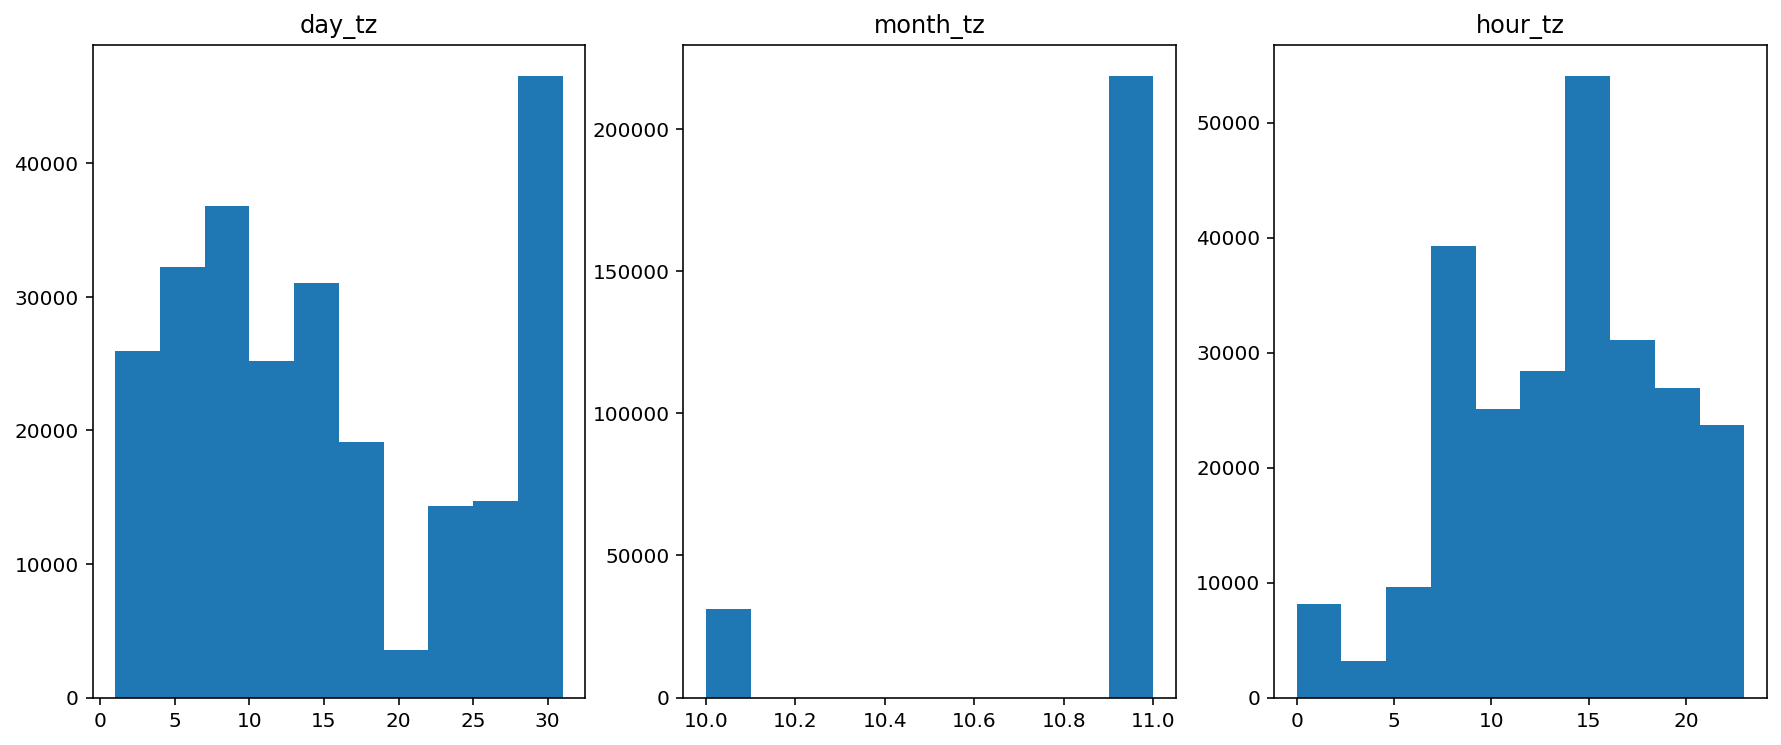

In [9]:
# for all users
fig, axs = plt.pyplot.subplots(1, 3, figsize=(15, 6), sharey=False)

axs[0].hist(df_e['day_tz'])
axs[0].set_title("day_tz")

axs[1].hist(df_e['month_tz'])
axs[1].set_title("month_tz")

axs[2].hist(df_e['hour_tz'])
axs[2].set_title("hour_tz")


Not really surprising, most visits were during the end of the month. We can clearly see that there many more samples during the month of November. Also, visits hours are usually around the middle of the day.

What is also interesting is that the 75% quantile value for the session time in `tiempodeses` indicates that very few visitors make up for the majority of the non-zero values. If I could guess all the zero-value records correspond to the non-visitor class.

In [10]:
# let's dig deeper around the non-visitor class and their relation with the time session
print("Mean of tiempodeses for non-visitors: ", df_e[df_e["visitor"] == 0]["tiempodeses"].mean())

print("Minimum value of tiempodeses for non-visitors: ", df_e[df_e["visitor"] == 0]["tiempodeses"].min())
print("Maximum value of tiempodeses for non-visitors: ", df_e[df_e["visitor"] == 0]["tiempodeses"].max())

df_e[df_e["visitor"] == 0]["tiempodeses"].describe()

Mean of tiempodeses for non-visitors:  4.385169677199475
Minimum value of tiempodeses for non-visitors:  0
Maximum value of tiempodeses for non-visitors:  1715


count    164312.00
mean          4.39
std          18.12
min           0.00
25%           0.00
50%           0.00
75%           0.00
max        1715.00
Name: tiempodeses, dtype: float64

We can clearly see a high relationship between non-visitors and low values in `tiempodeses`, we could consider outliers the ones with high values.

In order to see statistics on non-numerical features, one has to explicitly indicate data types of interest in the `include` parameter.

In [11]:
df_e.describe(include=["object", "bool"])

,device_mac,day_of_week_tz,visitor
count,249556,249556,249556
unique,125252,7,2
top,00:20:00:94:8e:d3,Wednesday,False
freq,489,48812,164312


Let's see the distribution of some of the non-numerical features. For plotting the distribution of categorical features we need to do a little bit of extra work and actually compute the frequency of the unique values, we can use the `value_counts` method to do so.

Text(0.5, 1.0, 'visitor')

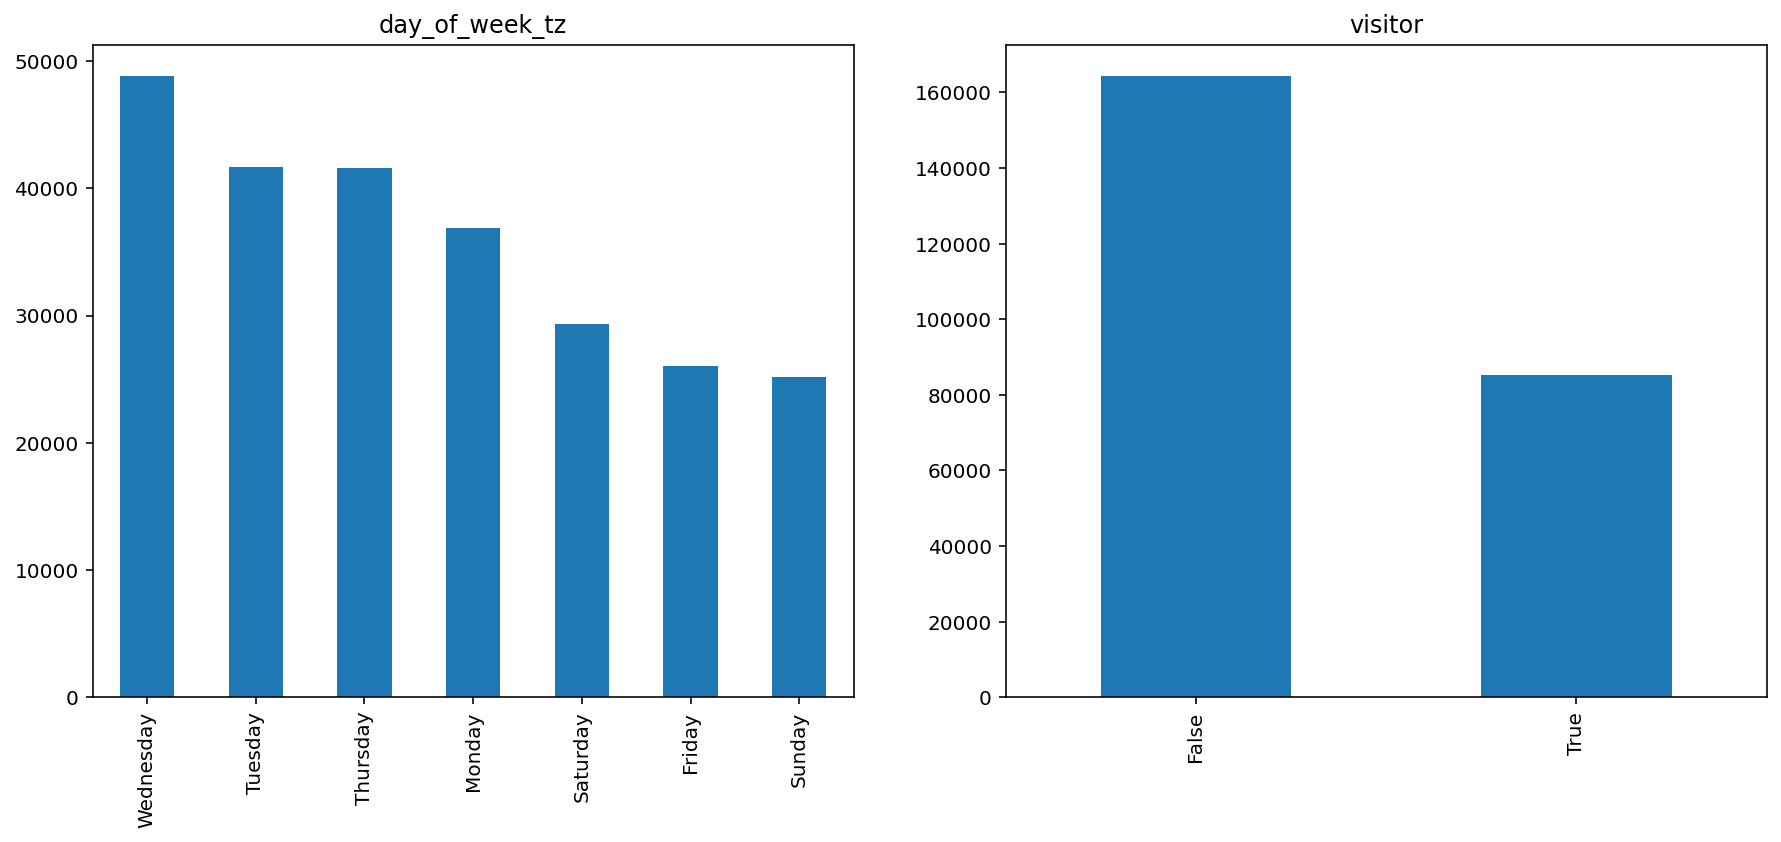

In [19]:
# for all users
fig, axs = plt.pyplot.subplots(1, 2, figsize=(15, 6), sharey=False)

df_e["day_of_week_tz"].value_counts().plot(kind="bar", ax=axs[0]).set_title("day_of_week_tz")
df_e["visitor"].value_counts().plot(kind="bar", ax=axs[1]).set_title("visitor")

For categorical (type `object`) and boolean (type `bool`) features we can use the `value_counts` method. Let's have a look at the distribution of Churn:

In [13]:
df_e['visitor'].value_counts()

False    164312
True      85244
Name: visitor, dtype: int64

We should be seeing the same distribution for the `int64` version of the feature.

In [14]:
df_e['visitor_int64'].value_counts()

0    164312
1     85244
Name: visitor_int64, dtype: int64

85244 users out of 249556 are actual visitors; their `visitor_int64` value is `1`. To calculate fractions, pass `normalize=True` to the `value_counts` function

In [15]:
df_e['visitor_int64'].value_counts(normalize=True)

0    0.66
1    0.34
Name: visitor_int64, dtype: float64

Let us keep answering questions, for example. What is the average number of visitors per day?

In [45]:
count_visitors = []
# for every unique value in day_of_week_tz
for i, day in enumerate(pd.unique(df_e['day_of_week_tz'])):
    # count, where visitor == 1 and day_of_week_tz == each unique value
    count_visitors.append(df_e[(df_e["visitor"] == 1) & (df_e["day_of_week_tz"] == day)]["tiempodeses"])
    print(f"{day}: ", count_visitors[i].count())

Wednesday:  15696
Sunday:  9930
Friday:  9189
Thursday:  13822
Saturday:  11117
Tuesday:  13515
Monday:  11975


Do we have the same patter for non-visitors?

In [46]:
count_non_visitors = []
# for every unique value in day_of_week_tz
for i, day in enumerate(pd.unique(df_e['day_of_week_tz'])):
    # count, where visitor == 1 and day_of_week_tz == each unique value
    count_non_visitors.append(df_e[(df_e["visitor"] == 0) & (df_e["day_of_week_tz"] == day)]["tiempodeses"])
    print(f"{day}: ", count_non_visitors[i].count())

Wednesday:  33116
Sunday:  15217
Friday:  16872
Thursday:  27773
Saturday:  18236
Tuesday:  28164
Monday:  24934


We see the same order of days of the week, this could be related to those users that got close to the branch but did not entered it. If that is the case, then this would mean that we could infer the general traffic around the branches, but that could be stretching the data too much.

In [65]:
# get totals to compute ratio
total_visitors = df_e[df_e["visitor"] == 1].shape[0]
total_non_visitors = df_e[df_e["visitor"] == 0].shape[0]
days_of_the_week = pd.unique(df_e['day_of_week_tz'])

# print ratios per day for visitors and non-visitors
for day, visitor_series, non_visitor_series in zip(days_of_the_week, count_visitors, count_non_visitors):
    print(f"{day}", "Visitors: ", len(visitor_series)/total_visitors, "-- Non-visitors: ", len(non_visitor_series)/total_non_visitors)

Wednesday Visitors:  0.18413026136736896 -- Non-visitors:  0.20154340522907638
Sunday Visitors:  0.1164891370653653 -- Non-visitors:  0.09261039972734797
Friday Visitors:  0.10779644315142414 -- Non-visitors:  0.1026827012025902
Thursday Visitors:  0.16214630941767164 -- Non-visitors:  0.16902599931836992
Saturday Visitors:  0.13041387077096336 -- Non-visitors:  0.11098398169336385
Tuesday Visitors:  0.15854488292431138 -- Non-visitors:  0.17140561857928818
Monday Visitors:  0.1404790953028952 -- Non-visitors:  0.1517478942499635


Let's summarize the data by showing the session time grouped by visitor and branch office to see what we can discover

In [66]:
columns_to_show = ["tiempodeses"]

df_e.groupby(["visitor", "branch_office"])[columns_to_show].agg([np.mean, np.std, np.min, np.max])

tiempodeses                      
                             mean       std amin   amax
visitor branch_office                                  
False   1                    5.26     18.44    0    315
        2                    6.25     19.94    0    214
        3                    3.09     17.35    0   1715
True    1                 7164.52  14177.94    0  68062
        2                 8979.42  12031.18    0  64424
        3                 5538.57   9454.80    0  64443

Users (visitors and non-visitors) spend, in average, more time in branch office number 2, however the variability of the session time, says that the less variable is branch office 3. Could this mean that office 3 has a better operation than the rest of the branches?

In [67]:
pd.crosstab(df_e["visitor"], df_e["branch_office"])

branch_office,1,2,3
visitor,,,
False,81927,11000,71385
True,45012,13542,26690


Sometimes sorting the values is helpful to better understand a behavior. We can do so by selecting one of the features (columns). We could start by sorting by `hour_tz`. Using the `ascending=False` we sort by descending order, `True` otherwise.

In [16]:
df_e.sort_values(by="hour_tz", ascending=True)

,Unnamed: 0,device_mac,branch_office,month_tz,day_tz,day_of_week_tz,hour_tz,visitor,tiempodeses,visitor_int64
0,1,00:00:00:6a:17:ce,1,11,2,Wednesday,0,True,2676,1
11766,11767,08:37:3d:f9:11:d8,1,11,8,Tuesday,0,False,0,0
11739,11740,08:37:3d:f9:11:d8,1,11,3,Thursday,0,False,0,0
11732,11733,08:37:3d:f9:11:d8,1,11,2,Wednesday,0,False,0,0
166737,166738,a8:bb:cf:ce:d5:35,1,10,28,Friday,0,False,0,0
...,...,...,...,...,...,...,...,...,...,...
43483,43484,30:0d:43:22:d6:98,3,11,11,Friday,23,True,3191,1
43492,43493,30:0d:43:22:d6:98,3,11,12,Saturday,23,True,9765,1
221614,221615,e8:50:8b:be:c7:d8,1,10,26,Wednesday,23,False,0,0
210786,210787,e0:98:61:d4:09:31,3,11,9,Wednesday,23,True,1921,1


We could leverage the rest of the time dimensionality in `day_tz` and `month_tz`. To sort by multiple columns we pass a `list` of values to the `by` parameter with the name of the features. Let's go ahead and also sort by `visitor`.

In [17]:
df_e.sort_values(by=["month_tz", "day_tz", "hour_tz"], ascending=[True, True, True])

,Unnamed: 0,device_mac,branch_office,month_tz,day_tz,day_of_week_tz,hour_tz,visitor,tiempodeses,visitor_int64
1560,1561,00:12:22:f6:54:08,1,10,24,Monday,12,True,1299,1
12748,12749,08:74:02:ad:a3:fa,1,10,24,Monday,12,True,10551,1
51186,51187,34:fc:ef:ed:7f:f8,1,10,24,Monday,12,True,5301,1
68435,68436,48:3b:38:a3:ee:9c,1,10,24,Monday,12,True,503,1
78626,78627,52:a2:0e:54:84:93,1,10,24,Monday,12,False,0,0
...,...,...,...,...,...,...,...,...,...,...
242060,242061,f4:f5:24:d3:4f:8a,1,11,30,Wednesday,17,True,123,1
242149,242150,f6:41:4d:fd:9b:84,1,11,30,Wednesday,17,False,0,0
243685,243686,f8:cf:c5:20:48:b4,1,11,30,Wednesday,17,False,0,0
243755,243756,f8:cf:c5:3e:7b:ca,1,11,30,Wednesday,17,False,0,0
